# Eddy Composites

The notebook creates figures related to eddy composites. Eddy composites were used to show the anomaly of surface chlorophyll (chapter 3.3.1), the vertical structure of anomalies in mesoscale eddies (chapter 3.1.2) and the three-dimensional anomaly of the vertical velocity (chapter 3.2.2). The following figures are created in this notebook:
- Figure 3.4: Vertical structure of temperature anomaly
- Figure 3.12: Vertical velocity anomaly in HR
- Figure 3.13: Vertical velocity anomaly in MR
- Figure 3.14: Average surface CHL anomaly

In [1]:
import sys                                                                                                                                                    
sys.path.append('/nfs/kryo/work/maxsimon/master-thesis/scripts')
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
import glob
from romstools.composite_tools import COMPOSITE_CORE, filter_by_chl, filter_by_mask, filter_by_dist, split_by_eddiesX, combine_filters, get_mean, mono_dipol_structure, plot_3d, plot_chl, CompositeManager
from romstools.cmap import W2G, W2G_r, DIFF, DIFF_r
from romstools.plot import plot_block
import warnings

## Load Data

In [2]:
## pactcs30

meso = CompositeManager(
    '/nfs/kryo/work/maxsimon/data/pactcs30/z/z_levels.nc',
    '/nfs/kryo/work/maxsimon/data/pactcs30/grid.npz',
    '/nfs/kryo/work/maxsimon/data/pactcs30/ssh/eddies-00000.nc',
    '/nfs/kryo/work/maxsimon/data/pactcs30/composites/r35x750x7-30d-'
)

In [3]:
## pactcs15

subm = CompositeManager(
    '/nfs/kryo/work/maxsimon/data/pactcs15/z/z_levels.nc',
    '/nfs/kryo/work/maxsimon/data/pactcs15/grid.npz',
    '/nfs/kryo/work/maxsimon/data/pactcs15/ssh/eddies-00000.nc',
    '/nfs/kryo/work/maxsimon/data/pactcs15/composites/r35x750x7-30d-'
)

In [4]:
## save data as dictionaries

runs = {
    'pactcs15': subm,
    'pactcs30': meso
}

NAMES = {
    'pactcs15': 'HR',
    'pactcs30': 'LR'
}

## Surface CHL Anomaly

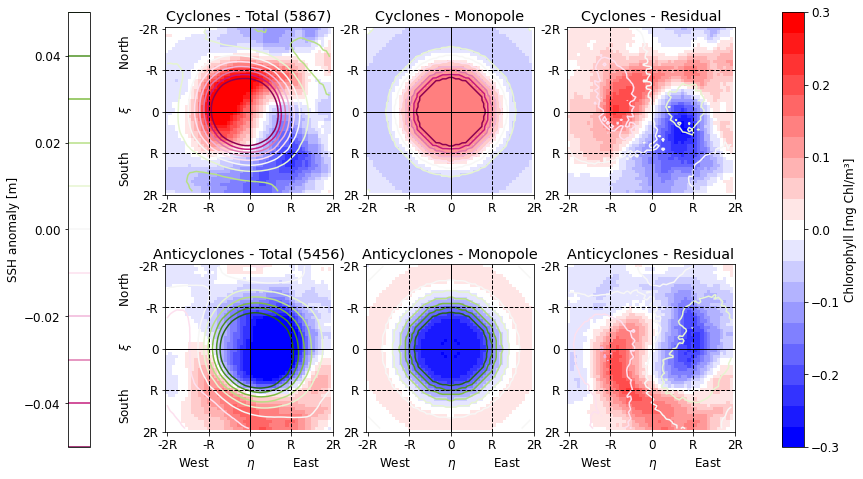

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(17, 8))

# get all eddies within 10km to 800km, average the first three (actually 6 because composites left out every second) depths
cyc_key = 'TOT_CHL {:s} gruber&dist10:800 doy1:400 avg0:3'

# for colorbars
cax = None
cax_zeta = None

scale = 'pactcs30'

for i, cyc in enumerate(('cycl', 'anti')):
    # construct full key
    key = cyc_key.format(cyc)
    
    # get zeta
    zeta_key = key.split(' ')
    zeta_key[0] = 'zeta'
    zeta_key[4] = '0'
    zeta_key = " ".join(zeta_key)
    
    # get name
    name = 'Cyclones' if cyc == 'cycl' else 'Anticyclones'
    
    # get full data
    res = runs[scale][key]
    
    # average over time
    mean_e = np.nanmean(runs[scale][key][:], axis=0)
    mean_z = np.nanmean(runs[scale][zeta_key][:], axis=0)
    # get the number of eddies used for this composites
    nitems = np.sum(runs[scale].num_items[key][:])
    nitems2 = np.sum(runs[scale].num_items[zeta_key][:])
    assert nitems == nitems2, (nitems, nitems2)
    
    # construct monopole and dipole
    mono, dipole = mono_dipol_structure(mean_e)
    zeta_mono, zeta_dipole = mono_dipol_structure(mean_z)
    
    # plot everything
    cax, cax_zeta = plot_chl(ax[i, 0], mean_e, mean_z, title=name+' - Total ({:d})'.format(nitems), v=(-0.3, 0.3), cmap='bwr')
    cax, cax_zeta = plot_chl(ax[i, 1], mono, zeta_mono, title=name+' - Monopole', v=(-0.3, 0.3), cmap='bwr')
    cax, cax_zeta = plot_chl(ax[i, 2], dipole, zeta_dipole, title=name+' - Residual', v=(-0.3, 0.3), cmap='bwr')
    
    # disable labels for all except first plot
    ax[i, 1].set_ylabel('')
    ax[i, 2].set_ylabel('')
    
for i in range(3):
    ax[0, i].set_xlabel('')
    
# colorbars
plt.colorbar(cax, ax=ax, location='right', label='Chlorophyll [mg Chl/m³]')
plt.colorbar(cax_zeta, ax=ax, location='left', label='SSH anomaly [m]')

plt.savefig('figures/result_composites_chl.pdf')
plt.show()

## Temperature Composites

In [13]:
## get composites for all (between 10 and 800km from coast) cyclones and anticyclones

temp_cycl_all = {
    scale: runs[scale]['temp cycl gruber&dist10:800 doy1:400'] for scale in runs
}

temp_anti_all = {
    scale: runs[scale]['temp anti gruber&dist10:800 doy1:400'] for scale in runs
}

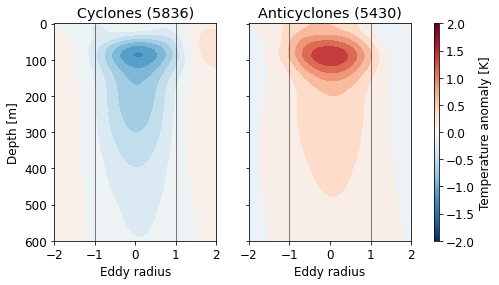

In [14]:
## plot temperature anomaly

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8, 4))

# get number of items
n_cycl = np.sum(runs['pactcs30'].num_items['temp cycl gruber&dist10:800 doy1:400'][1:])
n_anti = np.sum(runs['pactcs30'].num_items['temp anti gruber&dist10:800 doy1:400'][1:])
# plot a matrix somewhere outside to get a correct colorbar
cax = ax[0].imshow(np.array([[-2, -2], [2, 2]]), vmin=-2, vmax=2, cmap='RdBu_r', aspect='auto')

# plot cyclones (cut in center through xi)
ax[0].contourf(np.linspace(-2, 2, 51), runs['pactcs30'].zlevels, temp_cycl_all['pactcs30'][:, :, 25].mean(axis=0), cmap='RdBu_r', vmin=-2, vmax=2)
ax[0].set_title('Cyclones ({:d})'.format(n_cycl))

# plot anticyclones (cut in center through xi)
ax[1].contourf(np.linspace(-2, 2, 51), runs['pactcs30'].zlevels, temp_anti_all['pactcs30'][:, :, 25].mean(axis=0), cmap='RdBu_r', vmin=-2, vmax=2)
ax[1].set_title('Anticyclones ({:d})'.format(n_anti))

# plot grid
for i in range(2):
    ax[i].axvline(-1, ls='-', color='k', lw=0.5)
    ax[i].axvline(1, ls='-', color='k', lw=0.5)
    ax[i].set_xlabel('Eddy radius')

# set label
ax[0].set_ylabel('Depth [m]')
# colorbar
plt.colorbar(cax, ax=ax, label='Temperature anomaly [K]', location='right', aspect=40)

plt.savefig('figures/result_composites_temp.pdf')
plt.show()

## Vertical Velocity Composite

In [15]:
## calculate zeta for offshore region
zeta_cycl_offshore = {
    scale: runs[scale]['zeta cycl gruber&dist200:800 doy1:400 0'] for scale in runs
}

zeta_anti_offshore = {
    scale: runs[scale]['zeta anti gruber&dist200:800 doy1:400 0'] for scale in runs
}

In [16]:
## calculate vertical velocity (absolute value) for offshore region
wabs_cycl_offshore = {
    scale: runs[scale]['w cycl gruber&dist200:800 doy1:400 none rmsd'] for scale in runs
}

wabs_anti_offshore = {
    scale: runs[scale]['w anti gruber&dist200:800 doy1:400 none rmsd'] for scale in runs
}

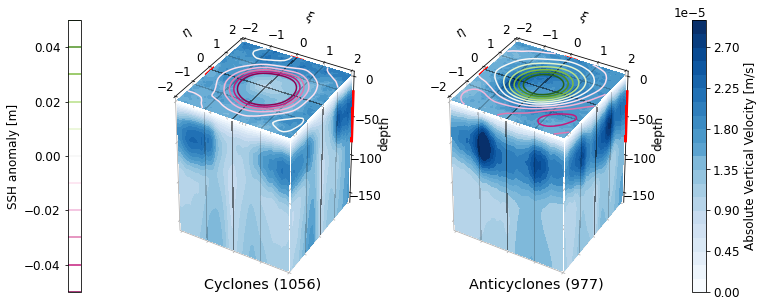

In [17]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15, 5))

# for joint colorbar
cax1, cax2 = None, None
cax = None

scale = 'pactcs15'

# get number of cyclones
n = np.sum(runs[scale].num_items['w cycl gruber&dist200:800 doy1:400 none rmsd'][1:45])
# plot cyclones (from doy 1 to 90, but need to devide by two)
cax1, cax2 = plot_3d(ax[0], runs['pactcs15'].zlevels[:15], wabs_cycl_offshore['pactcs15'][1:45, :15].mean(axis=0), zeta_cycl_offshore['pactcs15'][1:45].mean(axis=0), surface_range=slice(3, 10), v=(0, 3e-5), cmap='Blues')
ax[0].set_title('Cyclones ({:d})'.format(n), y=-0.01)

# get number of anticyclones
n = np.sum(runs[scale].num_items['w anti gruber&dist200:800 doy1:400 none rmsd'][1:45])
# plot anticyclones (from doy 1 to 90, but need to devide by two)
cax1, cax2 = plot_3d(ax[1], runs['pactcs15'].zlevels[:15], wabs_anti_offshore['pactcs15'][1:45, :15].mean(axis=0), zeta_anti_offshore['pactcs15'][1:45].mean(axis=0), surface_range=slice(3, 10), v=(0, 3e-5), cmap='Blues')
ax[1].set_title('Anticyclones ({:d})'.format(n), y=-0.01)

# colorbars
plt.colorbar(cax1, ax=ax, label='Absolute Vertical Velocity [m/s]')
plt.colorbar(cax2, ax=ax, location='left', label='SSH anomaly [m]')

plt.savefig('figures/result_composites_w-abs-p15.pdf')
plt.show()

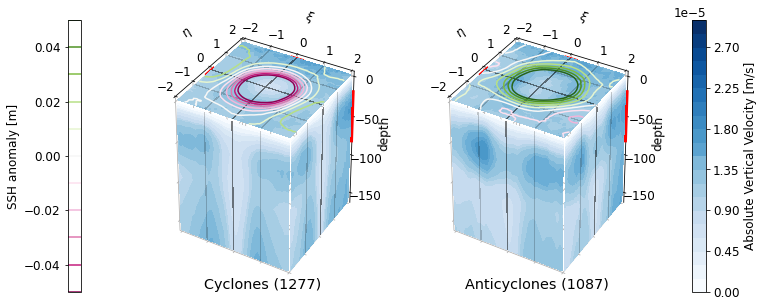

In [18]:
fig, ax = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize=(15, 5))

# for joint colorbar
cax1, cax2 = None, None
cax = None

scale = 'pactcs30'

# get number of cyclones
n = np.sum(runs[scale].num_items['w cycl gruber&dist200:800 doy1:400 none rmsd'][1:45])
# plot cyclones (from doy 1 to 90, but need to devide by two)
cax1, cax2 = plot_3d(ax[0], runs[scale].zlevels[:15], wabs_cycl_offshore[scale][1:45, :15].mean(axis=0), zeta_cycl_offshore[scale][1:45].mean(axis=0), surface_range=slice(3, 10), v=(0, 3e-5), cmap='Blues')
ax[0].set_title('Cyclones ({:d})'.format(n), y=-0.01)

# get number of anticyclones
n = np.sum(runs[scale].num_items['w anti gruber&dist200:800 doy1:400 none rmsd'][1:45])
# plot anticyclones (from doy 1 to 90, but need to devide by two)
cax1, cax2 = plot_3d(ax[1], runs[scale].zlevels[:15], wabs_anti_offshore[scale][1:45, :15].mean(axis=0), zeta_anti_offshore[scale][1:45].mean(axis=0), surface_range=slice(3, 10), v=(0, 3e-5), cmap='Blues')
ax[1].set_title('Anticyclones ({:d})'.format(n), y=-0.01)

# colorbars
plt.colorbar(cax1, ax=ax, label='Absolute Vertical Velocity [m/s]')
plt.colorbar(cax2, ax=ax, location='left', label='SSH anomaly [m]')

plt.savefig('figures/result_composites_w-abs-p30.pdf')
plt.show()